In [1]:
import matplotlib.transforms as transforms
import string
def add_letters(fig, ax, dx=-35/72., dy=15/72.):
    
    letterkwargs = dict(weight='bold', va='top', ha='left', fontsize=8)

    offset = transforms.ScaledTranslation(
            dx, dy, fig.dpi_scale_trans)

    for idx in range(len(ax)):
        ax[idx].text(0, 1, string.ascii_lowercase[idx], transform=ax[idx].transAxes + offset, 
                    **letterkwargs)

<>:228: SyntaxWarning: invalid escape sequence '\g'
<>:228: SyntaxWarning: invalid escape sequence '\g'
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_7220/417256324.py:228: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel("hyperparameter $\gamma$")


Current Working Directory: /Users/tflueh/Documents/PhD/subgroups_eval


/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_7220/417256324.py:90: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  grouped_acc_blind = df.groupby(["art1"]).apply(group_acc).reset_index(name='acc_blind')
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_7220/417256324.py:111: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_subgroup = df.groupby(col).apply(
/var/folders/xn/dwgv6q6n5j1b

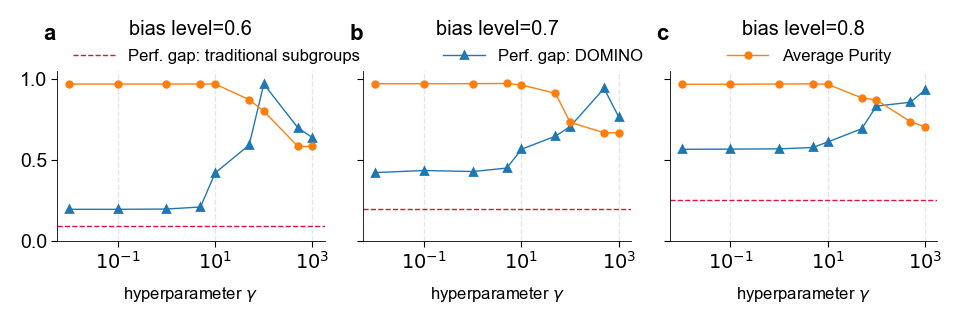

In [2]:
from sklearn.metrics import roc_auc_score, accuracy_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
import matplotlib.transforms as transforms
from matplotlib.offsetbox import AnnotationBbox, DrawingArea
import matplotlib.lines as mlines
from matplotlib.legend_handler import HandlerPatch

import os
#os.chdir("")  
print("Current Working Directory:", os.getcwd())

split = "test"

class HandlerDashedCircle(HandlerPatch):
    def create_artists(self, legend, orig_handle,
                       x0, y0, width, height, fontsize, trans):
        # The proxy circle will be centered in the legend box.
        center = (x0 + width/2., y0 + height/2.)
        # Use a radius that fits the box (here we use half the min dimension).
        radius = min(width, height) / 2.
        p = Circle(center, radius,
                   edgecolor=orig_handle.get_edgecolor(),
                   linestyle=orig_handle.get_linestyle(),
                   linewidth=orig_handle.get_linewidth(),
                   fill=False)
        self.update_prop(p, orig_handle, legend)
        p.set_transform(trans)
        return [p]
    
# Mapping true_sg values to (art1, art2)
mapping = {
    0: (0, 0),
    1: (0, 1),
    2: (1, 0),
    3: (1, 1)
}

# --- Sample Data: Replace with your file paths if reading from disk ---
with plt.style.context("./plot_style.txt"):
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    figheigth = textwidth/3 #textwidth/2.5
    fig, axes = plt.subplots(1, 3, figsize=(textwidth, figheigth), sharey=True, layout='constrained')
        
    for i, bias_level in enumerate(["0.6", "0.7", "0.8"]):
        
        # pick the i-th Axes
        ax = axes[i]

        data = "./results/results_persample_hypertag_valtest_{}_clip_imagenet_multiple.csv".format(bias_level)
        df = pd.read_csv(data)
        #print(df.columns)
        df = df[df["split"] == split]
        df[['art1', 'art2']] = df['true_subgroup_idx'].map(mapping).apply(pd.Series)


        df = df.pivot_table(
            index=['name', 'split', 'art1', 'y_true', 'y_pred'],
            columns=['seed', 'weight', 'n_slices'],
            values='discovered_subgroup_idx'
        ).reset_index()

        def flatten_column(col):
            # If the column is a tuple with exactly 3 elements,
            # assume it's from the pivoted values (seed, weight, n_slices)
            #print(len(col), col)
            if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
                seed, weight, n_slices = col
                return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
            # If it's a tuple with a single element, assume it's an index column
            elif isinstance(col, tuple) and len(col) == 1:
                return col[0]
            return col[0]

        df.columns = [flatten_column(col) for col in df.columns]

        def weight_fn(n, c=50):
            return n / (n + c)

        x = [0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]

        # Add horizontal line for blind performances
        def group_acc(df, y_true="y_true", y_pred="y_pred"):
            return accuracy_score(df[y_true], (df[y_pred] > 0.5)*1)
            
        grouped_acc_blind = df.groupby(["art1"]).apply(group_acc).reset_index(name='acc_blind')
        line_md = ax.axhline(np.abs(grouped_acc_blind["acc_blind"][0] - grouped_acc_blind["acc_blind"][1]), linestyle="dashed", color="crimson")
        #print("acc blind", np.abs(grouped_acc_blind["acc_blind"][0] - grouped_acc_blind["acc_blind"][1]))   
        # Choose an x position for the annotation – here we take the center of the current x-axis
        x_center = 0.01

        # Add an annotation above the line. To place it below, subtract from y_value instead.
        #line = ax.annotate("Traditional subgroup analysis",
        #            xy=(x_center, np.abs(grouped_acc_blind["acc_blind"][0] - grouped_acc_blind["acc_blind"][1])),             # point being annotated (on the line)
        #            xytext=(x_center, np.abs(grouped_acc_blind["acc_blind"][0] - grouped_acc_blind["acc_blind"][1]) + 0.01),    # text location, 0.03 units above the line
        #            textcoords="data",fontsize=5,
        #            color="gray",
        #            #arrowprops=dict(arrowstyle="->", color="gray")
        #           )

        perf_gaps = []
        for col in df.columns:
            if "discovered_subgroup_idx" in col:
                weight = col.split("_")[4][1:]
                if float(weight) in x:
                    # calculate the performance per subgroup
                    perf_subgroup = df.groupby(col).apply(
                        lambda x: pd.Series({
                            "accuracy": accuracy_score(x["y_true"], (x["y_pred"] > 0.5)*1),
                        })
                    ).reset_index()
                    # get the maximum performance gap across subgroups
                    #print("#"*5)
                    #print(perf_subgroup)
                    perf_gap = perf_subgroup["accuracy"].max() - perf_subgroup["accuracy"].min()
                    weight = col.split("_")[4][1:]
                    perf_gaps.append(perf_gap)
                    #print("perf. gaps", col, weight, perf_gap)

        balanced_purr_arr = []
        
        for col in df.columns:
            if "discovered_subgroup_idx" in col:
                weight = col.split("_")[4][1:]
                if float(weight) in x:
                    # calculate the purity of the majority true_subgroup_idx per subgroup
                    subgroups = df.groupby(col)
                    purity = subgroups.apply(
                        lambda x: pd.Series({
                            "number_of_samples": len(x),
                            "majority_true_subgroup_idx": x["art1"].value_counts().idxmax(),
                            "max_purity": x["art1"].value_counts(normalize=True).max()
                        })
                    ).reset_index()

                    # Compute adjusted purity for each subgroup
                    purity["adjusted_purity"] = purity.apply(
                        lambda row: row["max_purity"] * weight_fn(row["number_of_samples"]),
                        axis=1
                    )
                    
                    # = subgroups.apply(
                    #    lambda x: x["true_subgroup_idx"].value_counts(normalize=True).max()
                    #)
                    # get the balanced average max_purity across unique majority_true_subgroup_idx
                    purities_per_group = []
                    for group_idx in range(2):
                        max_purity = purity[purity["majority_true_subgroup_idx"] == group_idx]["adjusted_purity"].max()
                        purities_per_group.append(max_purity)

                    balanced_purities = np.mean(purities_per_group)
                    balanced_purr_arr.append(balanced_purities)
                    #get weight from col name
                    weight = col.split("_")[4][1:]
                    #print("purity", weight, col, balanced_purities)

        #x = [ 0.01, 0.1, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]
        
        #if i == 0:
        line_pg, = ax.plot(x, perf_gaps, marker="^", label="Performance Gap", markersize=2)
        line_bp, = ax.plot(x, balanced_purr_arr, marker="o", label="Balanced Purity", markersize=2)
        #ax.legend(position="upper right")
        #else:
        #    line_pg, = ax.plot(x, perf_gaps, marker="^", linestyle="--", markersize=2)
        #    line_bp, = ax.plot(x, balanced_purr_arr, marker="o", markersize=2)

        x_val = 10
        y_val = balanced_purr_arr[x.index(x_val)]  # or simply y[2] if you know the index
        disp_coords = ax.transData.transform((x_val, y_val))
        # Define the desired circle radius in pixels
        radius_pixels = 3

        # Create a drawing area that will contain our circle.
        # Its width and height are set so the circle fits (diameter = 2 * radius).
        #da = DrawingArea(2*radius_pixels, 2*radius_pixels, 0, 0)

        # Create a circle patch that is centered in the drawing area.
        # Note: In the drawing area, (radius_pixels, radius_pixels) is the center.
        #circle = Circle((radius_pixels, radius_pixels),
        #                radius=radius_pixels,
        #                edgecolor='red',
        #                linestyle='dashed',
        #                fill=False,
        #                linewidth=0.5)
        #da.add_artist(circle)

        # Create an AnnotationBbox to anchor the drawing area at the data coordinates.
        #ab = AnnotationBbox(da, (x_val, y_val),
        #                    xycoords='data',
        #                    frameon=False)
        #ax.add_artist(ab)

        # Create a custom legend handle for the highlighted circle.
        # --- Create a proxy artist for the legend ---
        # We create a dummy Circle patch that mimics the appearance of our annotation.
        proxy_md = mlines.Line2D([], [], color=line_md.get_color(),
                         linestyle=line_md.get_linestyle(),
                         marker=line_md.get_marker(),
                         markersize=line_md.get_markersize(),
                         label="Performance gap: traditional subgroups")
        proxy_pg = mlines.Line2D([], [], color=line_pg.get_color(),
                         linestyle=line_pg.get_linestyle(),
                         marker=line_pg.get_marker(),
                         markersize=line_pg.get_markersize(),
                         label="Performance gap: DOMINO")
        proxy_bp = mlines.Line2D([], [], color=line_bp.get_color(),
                         linestyle=line_bp.get_linestyle(),
                         marker=line_bp.get_marker(),
                         markersize=line_bp.get_markersize(),
                         label="Balanced Purity")

        #proxy_circle = Circle((0, 0), radius=5, 
        #                    edgecolor='red', 
        #                    linestyle='dashed', 
        #                    fill=False, 
        #                    linewidth=0.5)

        # Retrieve current handles/labels from the plot
        handles = [proxy_md, proxy_pg, proxy_bp]
        labels = ["Perf. gap: traditional subgroups", "Perf. gap: DOMINO", "Average Purity"]

        ax.set_title(f"bias level={bias_level}", pad=13)
        ax.set_xscale("log")
        ax.set_xlabel("hyperparameter $\gamma$")
        ax.set_xticks([0.1, 10, 1000])
        ax.set_xticklabels([r'$10^{-1}$', r'$10^{1}$', r'$10^{3}$'])
        ax.set_ylim(0, 1.05)
        # only vertical grid lines
        ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.2)
    

    # Create the legend, specifying the custom handler for Circle patches.
    
    fig.legend(handles=handles, labels=labels,
           loc="upper center", ncols=3, bbox_to_anchor=(0.5, 0.9),
           columnspacing=5,  # Adjust the spacing between columns
           handlelength=2.5,  # Adjust the length of the legend handles
           # handleheight=2,  # Adjust the height of the legend handles
           frameon=False)
    # fig.legend(handles=handles, labels=labels,
    #        loc="center left",  # Position the legend on the left of the figure
    #        bbox_to_anchor=(1, 0.5),  # Anchor the legend to the right side of the plot
    #        ncol=1,  # Number of columns in the legend
    #        handlelength=2.5,  # Length of the legend handles
    #        handleheight=2,  # Adjust height of the handles
    #        frameon=False)  # Hide the legend frame



    
    #fig.legend(loc="upper center", ncols=2, bbox_to_anchor=(0.5, .9), frameon=False)
    add_letters(fig, axes, dx=-textwidth/72., dy=17/72) 
    fig.tight_layout()
    plt.savefig("l2_ablation_{}_art1only_hline_2302.pdf".format(split), bbox_inches="tight")

    #plt.ylabel("Performance Gap / Balanced Purity")
    plt.show()
        


# Purity of subgroups wrt metadata

In [11]:
# Prepare metadata

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO
import numpy as np


metadata = "./results/susu_ERM_hypertag_stoic-energy-14_test_tsne_metadata.csv"
md_df = pd.read_csv(metadata)
md_df
# Comorbidity columns with [1, 0, -1, nan] values
comorbidity_columns = ['Enlarged Cardiomediastinum', 'Cardiomegaly', 'Lung Opacity',
                       'Lung Lesion', 'Edema', 'Consolidation', 'Pneumonia',
                       'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
                       'Pleural Other', 'Fracture', 'Support Devices', 'No Finding']

# Categorical variables
categorical_columns = ['sex', 'race', 'ethnicity', 'interpreter_needed',
                       'insurance_type', 'deceased']

# Continuous variables
continuous_columns = ['age', 'recent_bmi']

def map_comorbidity_values(value):
    if pd.isna(value):
        return 'missing'
    elif value == 1:
        return 'positive'
    elif value == 0:
        return 'uncertain'
    elif value == -1:
        return 'negative'
    else:
        return 'other'  # For any unexpected values

# Apply mapping to comorbidity columns
for col in comorbidity_columns:
    md_df[col] = md_df[col].apply(map_comorbidity_values)
    
# Define bins for 'age'
age_bins = [0, 40, 60, np.inf]
age_labels = ['0-40', '40-60', '60+']
md_df['age_bin'] = pd.cut(md_df['age'], bins=age_bins, labels=age_labels, right=False)

# Define bins for 'recent_bmi'
bmi_bins = [0, 18.5, 25, 30, 40, np.inf]
bmi_labels = ['Underweight', 'Normal', 'Overweight', 'Obese', 'Morbidly Obese']
md_df['bmi_bin'] = pd.cut(md_df['recent_bmi'], bins=bmi_bins, labels=bmi_labels, right=False)

binned_columns = ['age_bin', 'bmi_bin']

attributes_to_process = comorbidity_columns + categorical_columns + binned_columns




In [12]:
# Load imagenet clip results

from sklearn.metrics import roc_auc_score, accuracy_score


data = "./results/results_persample_l3_valtest_clip_imagenet_multiple.csv"
df = pd.read_csv(data)
df = df[df["split"] == "test"]
#df = df[df["weight"] == 20]
#df = df[df["seed"] == 10]
#df = df[df["n_slices"] == 15]


df = df.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

def flatten_column(col):
    # If the column is a tuple with exactly 3 elements,
    # assume it's from the pivoted values (seed, weight, n_slices)
    #print(len(col), col)
    if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
        seed, weight, n_slices = col
        return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
    # If it's a tuple with a single element, assume it's an index column
    elif isinstance(col, tuple) and len(col) == 1:
        return col[0]
    return col[0]

df.columns = [flatten_column(col) for col in df.columns]

md_df['name'] = md_df['name'].str.replace(r'^.*train/', 'train/', regex=True)

df = pd.merge(df, md_df, how="inner", on="name")

# Define the weighting function (tune c as needed)
def weight_fn(n, c=50):
    return n / (n + c)
balanced_purr_arr = {}
perf_gaps = []

md_cols = ["sex", "age_bin", "bmi_bin", "race", "insurance_type", "Support Devices", "Edema"]
x_full = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100, 500, 1000]


for col in df.columns:
    if "discovered_subgroup_idx" in col:
        # calculate the performance per subgroup
        weight = float(col.split("_")[4][1:])
        if weight in x_full:
            perf_subgroup = df.groupby(col).apply(
                lambda x: pd.Series({
                    "accuracy": accuracy_score(x["y_true"], (x["y_pred"] > 0.5)*1),
                })
            ).reset_index()
            # get the maximum performance gap across subgroups
            #print("#"*5)
            #print(perf_subgroup)
            perf_gap = perf_subgroup["accuracy"].max() - perf_subgroup["accuracy"].min()
            perf_gaps.append(perf_gap)
            #print("perf. gaps", col, weight, perf_gap)


for md_col in md_cols:
    balanced_purr_arr[md_col] = []
    for col in df.columns:
        if "discovered_subgroup_idx" in col:
            weight = float(col.split("_")[4][1:])
            if weight in x_full:
                subgroups = df.groupby(col)
                purity = subgroups.apply(
                    lambda x: pd.Series({
                        "number_of_samples": len(x),
                        "majority_true_subgroup_idx": x[md_col].value_counts().idxmax(),
                        "max_purity": x[md_col].value_counts(normalize=True).max()
                    })
                ).reset_index()
    
                # Compute adjusted purity for each subgroup
                purity["adjusted_purity"] = purity.apply(
                    lambda row: row["max_purity"] * weight_fn(row["number_of_samples"]),
                    axis=1
                )
                            
                # For each ground truth subgroup, find the discovered subgroup with the best adjusted purity
                adjusted_purities_per_group = []
    
                unique_cols = df[md_col].unique()
                for group_idx in range(len(unique_cols)):
                    grp = purity[purity["majority_true_subgroup_idx"] == unique_cols[group_idx]]
                    if not grp.empty:
                        best_adjusted_purity = grp["adjusted_purity"].max()
                    else:
                        best_adjusted_purity = 0
                    #print(f"Ground truth group {group_idx}: best adjusted purity = {best_adjusted_purity}")
                    adjusted_purities_per_group.append(best_adjusted_purity)
    
                balanced_adjusted_purity = np.mean(adjusted_purities_per_group)
                balanced_purr_arr[md_col].append(balanced_adjusted_purity)
                weight = col.split("_")[4][1:]
                #print("Adjusted purity", weight, col, balanced_adjusted_purity)


/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/3686746088.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_subgroup = df.groupby(col).apply(
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/3686746088.py:53: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_subgroup = df.groupby(col).apply(
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/368674608

In [13]:
# Load cxr clip results

split = "test"

data_cxr = "./results/results_persample_l3_valtest_clip_cxr_multiple.csv"
df_cxr = pd.read_csv(data_cxr)
df_cxr = df_cxr[df_cxr["split"] == split]
#df = df[df["weight"] == 20]
#df = df[df["seed"] == 10]
#df = df[df["n_slices"] == 15]


df_cxr = df_cxr.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

df_cxr.columns = [flatten_column(col) for col in df_cxr.columns]

md_df['name'] = md_df['name'].str.replace(r'^.*train/', 'train/', regex=True)

df_cxr = pd.merge(df_cxr, md_df, how="inner", on="name")

# Define the weighting function (tune c as needed)
def weight_fn(n, c=50):
    return n / (n + c)
cxr_balanced_purr_arr = {}
perf_gaps_cxr = []

x_partial = [0.001, 0.01, 0.1, 1, 5, 10, 50, 100]

for col in df_cxr.columns:
    if "discovered_subgroup_idx" in col:
        # calculate the performance per subgroup
        weight = float(col.split("_")[4][1:])
        if weight in x_partial:
            perf_subgroup = df_cxr.groupby(col).apply(
                lambda x: pd.Series({
                    "accuracy": accuracy_score(x["y_true"], (x["y_pred"] > 0.5)*1),
                })
            ).reset_index()
            # get the maximum performance gap across subgroups
            #print("#"*5)
            #print(perf_subgroup)
            perf_gap = perf_subgroup["accuracy"].max() - perf_subgroup["accuracy"].min()
            perf_gaps_cxr.append(perf_gap)
            #print("perf. gaps", col, weight, perf_gap)


md_cols = ["sex", "age_bin", "bmi_bin", "race", "insurance_type", "Support Devices", "Edema"]

for md_col in md_cols:
    cxr_balanced_purr_arr[md_col] = []
    for col in df_cxr.columns:
        if "discovered_subgroup_idx" in col:
            weight = float(col.split("_")[4][1:])
            if weight in x_partial:
                subgroups = df_cxr.groupby(col)
                purity = subgroups.apply(
                    lambda x: pd.Series({
                        "number_of_samples": len(x),
                        "majority_true_subgroup_idx": x[md_col].value_counts().idxmax(),
                        "max_purity": x[md_col].value_counts(normalize=True).max()
                    })
                ).reset_index()
    
                # Compute adjusted purity for each subgroup
                purity["adjusted_purity"] = purity.apply(
                    lambda row: row["max_purity"] * weight_fn(row["number_of_samples"]),
                    axis=1
                )
                
                # For each ground truth subgroup, find the discovered subgroup with the best adjusted purity
                adjusted_purities_per_group = []
    
                unique_cols = df_cxr[md_col].unique()
                for group_idx in range(len(unique_cols)):
                    grp = purity[purity["majority_true_subgroup_idx"] == unique_cols[group_idx]]
                    if not grp.empty:
                        best_adjusted_purity = grp["adjusted_purity"].max()
                    else:
                        best_adjusted_purity = 0
                    #print(f"Ground truth group {group_idx}: best adjusted purity = {best_adjusted_purity}")
                    adjusted_purities_per_group.append(best_adjusted_purity)
    
                balanced_adjusted_purity = np.mean(adjusted_purities_per_group)
                cxr_balanced_purr_arr[md_col].append(balanced_adjusted_purity)
                weight = col.split("_")[4][1:]
                #print("Adjusted purity", weight, col, balanced_adjusted_purity)


/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/1218296350.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_subgroup = df_cxr.groupby(col).apply(
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/1218296350.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perf_subgroup = df_cxr.groupby(col).apply(
/var/folders/xn/dwgv6q6n5j1bbv3kb2l7nkfr0000gn/T/ipykernel_11099/1

<>:150: SyntaxWarning: invalid escape sequence '\g'
<>:150: SyntaxWarning: invalid escape sequence '\g'
/scratch/local/16299170/ipykernel_1178511/4138512893.py:150: SyntaxWarning: invalid escape sequence '\g'
  ax.set_xlabel("hyperparameter $\gamma$")
/scratch/local/16299170/ipykernel_1178511/4138512893.py:39: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' no

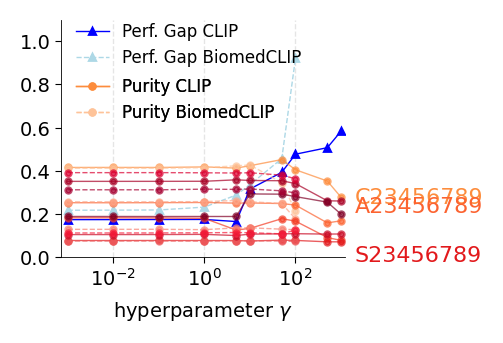

In [17]:
import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
import matplotlib.cm as cm
from matplotlib.lines import Line2D

def create_figure(n_rows, linewidth=3.0, axes_height=1.5, axes_width_fraction=0.8,
                  top_margin_inches=0.3, bottom_margin_inches=0.3, vertical_spacing_inches=0.2):
    """
    Creates a figure with n_rows subplots where each subplot (the drawing area)
    has the same fixed width and height.

    Parameters:
      - n_rows: Number of rows of subplots.
      - linewidth: Total figure width in inches.
      - axes_height: Desired height of each subplot's drawing area (in inches).
      - axes_width_fraction: Fraction of the total width that the drawing area should occupy.
      - top_margin_inches, bottom_margin_inches: Top and bottom margins (in inches).
      - vertical_spacing_inches: Vertical space between subplots (in inches).

    Returns:
      - fig: The created figure.
      - axes: A list (or array) of axes objects.
    """
    # Compute overall figure height so that each axes is axes_height tall.
    fig_height = top_margin_inches + bottom_margin_inches + n_rows * axes_height + (n_rows - 1) * vertical_spacing_inches

    # Create the figure with the total width and computed height.
    fig, axes = plt.subplots(n_rows, 1, figsize=(linewidth, fig_height), sharex=True)

    # Determine normalized margins so that the axes drawing area has fixed size.
    left = (1 - axes_width_fraction) / 2
    right = 1 - left
    bottom = bottom_margin_inches / fig_height
    top = 1 - top_margin_inches / fig_height
    # hspace is given relative to the axes height.
    hspace = vertical_spacing_inches / axes_height

    fig.subplots_adjust(left=left, right=right, bottom=bottom, top=top, hspace=hspace)
    return fig, axes


def lighten_color(color, amount=1.1):
    """
    Lightens the given color by converting to HLS and increasing the lightness.
    
    Parameters:
        color: A matplotlib color string, hex string, or RGB tuple.
        amount: A factor; values >1 make the color lighter, values <1 make it darker.
        
    Returns:
        A lightened RGB tuple.
    """
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = mc.to_rgb(c)
    h, l, s = colorsys.rgb_to_hls(*c)
    l = min(1, l * amount)
    return colorsys.hls_to_rgb(h, l, s)

with plt.style.context("./plot_style.txt"):
    
    # Define your metadata columns and their custom labels.
    md_cols = ["sex", "age_bin", "bmi_bin", "race", "insurance_type", "Support Devices", "Edema"]
    custom_labels = ["Sex", "Age Group", "BMI Category", "Ethnicity", "Insurance", "Support Devices", "Edema"]
    
    # Use the YlOrRd colormap over a restricted range (0.5 to 1.0) to get vivid colors.
    cmap_yellow_red = plt.get_cmap("YlOrRd")
    n = len(md_cols)
    base_colors = {md: cmap_yellow_red(0.5 + 0.5 * i/(n-1)) for i, md in enumerate(md_cols)}
    
    cm = 1/2.54  # centimeters in inches
    # Create subplots ONCE
    textwidth = 12.19826*cm
    #fig, ax = create_figure(n_rows=1, axes_height=textwidth/3, axes_width_fraction=0.7)
    #fig, ax = plt.subplots(figsize=(textwidth/2, textwidth/2.5))
    fig, ax = create_figure(n_rows=1, linewidth=textwidth/2, axes_height=textwidth/4.8, axes_width_fraction=0.6)


    
    
    #fig, ax = plt.subplots(figsize=(4, 3))
    
    # --- Plot performance gap curves (in blue) ---
    ax.plot(x_full, perf_gaps, marker="^", linestyle="solid",
            color="blue", label="Perf. Gap CLIP", markersize=2)
    ax.plot(x_partial, perf_gaps_cxr, marker="^", linestyle="dashed",
            color="lightblue", label="Perf. Gap CXR CLIP", markersize=2)
    
    # --- Plot metadata purity curves in vivid yellow-to-red ---
    for md in md_cols:
        # Solid line: balanced group (ImageNet CLIP purity).
        ax.plot(x_full, balanced_purr_arr[md],
                marker="o", linestyle="solid", alpha=0.7, markersize=2,
                color=base_colors[md])
        # Dashed line: CXR group purity, using a slightly lightened version.
        ax.plot(x_partial, cxr_balanced_purr_arr[md],
                marker="o", linestyle="dashed", alpha=0.7, markersize=2,
                color=lighten_color(base_colors[md], amount=1.3))
    
    # --- Annotate selected key metadata curves ---
    # We highlight only "Sex", "Age Group", and "Ethnicity".
    selected_md = {
        "sex": "C23456789",#"Sex",
        "age_bin": "A23456789", #"Age Group",
        "race": "S23456789", #"Ethnicity"
    }
    # Offsets (in points) to avoid overlapping text.
    offsets = {
        "sex": (5, 0),
        "age_bin": (5, 5),
        "race": (5, -5)
    }
    for md, label in selected_md.items():
        y_val = balanced_purr_arr[md][-1]
        dx, dy = offsets.get(md, (5, 0))
        ax.annotate(label,
                    xy=(x_full[-1], y_val),
                    xytext=(dx, dy),
                    textcoords="offset points",
                    ha="left",
                    va="center",
                    color=base_colors[md],
                    fontsize=8)
    
    # --- Create a legend for performance gap curves ---
    perf_handles = [
        Line2D([], [], color='blue', marker="^", markersize=2, linestyle="solid", label="Perf. Gap CLIP"),
        Line2D([], [], color='lightblue', marker="^", markersize=2, linestyle="dashed", label="Perf. Gap BiomedCLIP")
    ]
    perf_legend = ax.legend(handles=perf_handles, loc='upper left', bbox_to_anchor=(0, 1.05), frameon=False)
    ax.add_artist(perf_legend)
    
    # --- Create a legend for purity curves (metadata-based) ---
    purity_handles = [
        Line2D([], [], color=base_colors["sex"], marker="o", markersize=2, linestyle="solid", label="Purity CLIP"),
        Line2D([], [], color=lighten_color(base_colors["sex"], amount=1.3), markersize=2, marker="o", linestyle="dashed", label="Purity BiomedCLIP")
    ]
    purity_legend = ax.legend(handles=purity_handles, loc='upper left', bbox_to_anchor=(0, 0.82), frameon=False)
    ax.add_artist(purity_legend)
    
    # --- Configure the plot ---
    ax.set_xscale("log")
    ax.set_ylim(0, 1.1)
    ax.set_xlim(0.0007, 1200)
    ax.set_xticks([0.01, 1, 100])
    ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
    ax.set_xlabel("hyperparameter $\gamma$")
    ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.2)

    ax.autoscale(enable=False)
    
    plt.savefig("l3_ablation_{}_2302_half.pdf".format(split))
    plt.show()



findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial
findfont: Generic family 'sans-serif' not found because

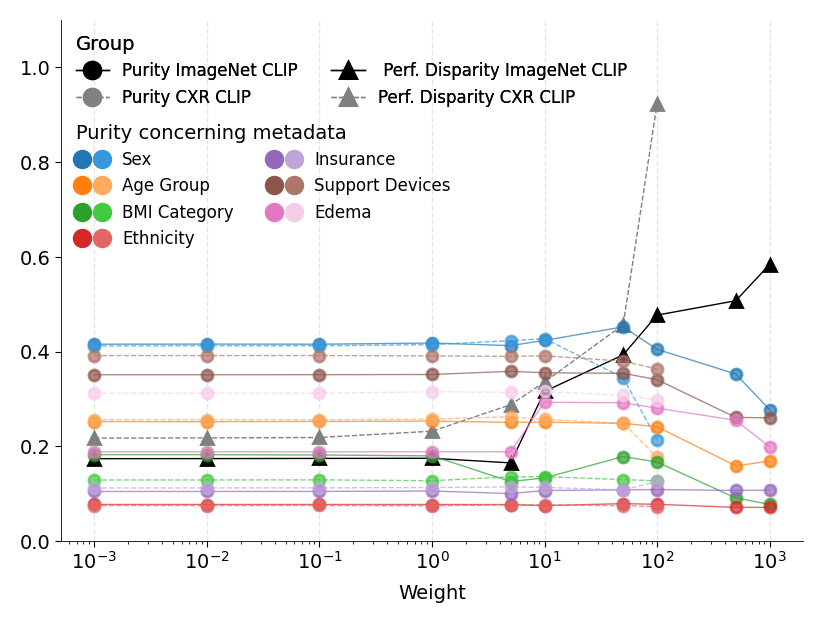

In [5]:
## PLOT WITH ALL THE COLORS AND COLUMNS SEPARATED WITH LEGEND

import matplotlib.pyplot as plt
import matplotlib.colors as mc
import colorsys
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerTuple


def lighten_color(color, amount=2):
    """
    Lightens the given color by converting to HLS and increasing the lightness.
    
    Parameters:
        color: A matplotlib color string, hex string, or RGB tuple.
        amount: A factor; values >1 make the color lighter, values <1 make it darker.
        
    Returns:
        A lightened RGB tuple.
    """
    try:
        c = mc.cnames[color]
    except KeyError:
        c = color
    c = mc.to_rgb(c)
    # Convert RGB to HLS (Hue, Lightness, Saturation)
    h, l, s = colorsys.rgb_to_hls(*c)
    # Increase lightness, but cap it at 1
    l = min(1, l * amount)
    return colorsys.hls_to_rgb(h, l, s)

with plt.style.context("./plot_style.txt"):
        
    # Define your md_cols.
    md_cols = ["sex", "age_bin", "bmi_bin", "race", "insurance_type", "Support Devices", "Edema"]

    # Assign a base color to each md_col.
    prop_cycle = plt.rcParams['axes.prop_cycle']
    colors = prop_cycle.by_key()['color']
    base_colors = {md: colors[i % len(colors)] for i, md in enumerate(md_cols)}

    # Define x-values.
    #x_full    = [0.001, 0.01, 0.1, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250, 500, 750, 1000]
    #x_partial = [0.001, 0.01, 0.1, 1, 2.5, 5, 7.5, 10, 25, 50, 75, 100, 250]

    # Create a figure and axis.
    fig, ax = plt.subplots(figsize=(4, 3))


    ax.plot(x_full, perf_gaps, marker="^", linestyle="solid", clip_on=False, color="black", label="ImageNet CLIP", markersize=4,)
    ax.plot(x_partial, perf_gaps_cxr, marker="^", linestyle="dashed", clip_on=False, color="gray", label="CXR CLIP", markersize=4,)

    # Plot both groups (balanced and cxr).
    for md in md_cols:
        # First group: solid lines
        ax.plot(x_full, balanced_purr_arr[md],
                marker="o", linestyle="solid", alpha=0.7, markersize=4, clip_on=False,
                color=base_colors[md])
        # Second group: dashed lines with a lightened color
        ax.plot(x_partial, cxr_balanced_purr_arr[md],
                marker="o", linestyle="dashed", alpha=0.7, markersize=4, clip_on=False,
                color=lighten_color(base_colors[md], amount=1.3))

    # Create combined legend handles (a tuple with two line styles per md_col)
    handles = []
    for md in md_cols:
        solid_line = Line2D([], [], color=base_colors[md], marker="o", linestyle="solid")
        dashed_line = Line2D([], [], color=lighten_color(base_colors[md], amount=1.3), marker="o", linestyle="dashed")
        handles.append((solid_line, dashed_line))

    custom_labels = ["Sex", "Age Group", "BMI Category", "Ethnicity", "Insurance", "Support Devices", "Edema"]

    # Create the combined legend for md_cols, and place it behind the one in the upper left.
    combined_legend = ax.legend(handles, custom_labels, handler_map={tuple: HandlerTuple(ndivide=2)},
                                title="Purity concerning metadata", loc='upper left', bbox_to_anchor=(0, 0.83), ncols=2, frameon=False)
    combined_legend._legend_box.align = "left"
    ax.add_artist(combined_legend)

    # Create a separate custom legend for the line styles.
    style_handles = [
        Line2D([], [], color='black', marker="o", linestyle="solid", label="Purity ImageNet CLIP"),
        Line2D([], [], color='gray', marker="o", linestyle="--", label="Purity CXR CLIP"),
        Line2D([], [], color='black', marker="^", linestyle="solid", label=" Perf. Disparity ImageNet CLIP"),
        Line2D([], [], color='gray', marker="^", linestyle="--", label="Perf. Disparity CXR CLIP"),
        
    ]
    style_legend = ax.legend(handles=style_handles, title="Group", loc='upper left', ncols=2, frameon=False)
    style_legend._legend_box.align = "left"
    ax.add_artist(style_legend)

    # Configure the plot.
    ax.set_xscale("log")
    ax.set_ylim(0, 1.1)
    ax.set_xlabel("Weight")
    ax.grid(axis='x', color='gray', linestyle='--', linewidth=0.5, alpha=0.2)
    
    #plt.savefig("l3_ablation_{}.pdf".format(split), bbox_inches="tight")

    plt.show()

    


# Investigate why for validation the balanced purity still goes up at high values of the hyperparameter

In [6]:
# --- Sample Data: Replace with your file paths if reading from disk ---
bias_level = "0.6"

data = "../results/results_persample_hypertag_valtest_{}_clip_imagenet_multiple.csv".format(bias_level)
df = pd.read_csv(data)
print(df.columns)
df = df[df["split"] == "val"]
df = df[df["weight"] == 10]

df = df.pivot_table(
    index=['name', 'split', 'true_subgroup_idx', 'y_true', 'y_pred'],
    columns=['seed', 'weight', 'n_slices'],
    values='discovered_subgroup_idx'
).reset_index()

def flatten_column(col):
    # If the column is a tuple with exactly 3 elements,
    # assume it's from the pivoted values (seed, weight, n_slices)
    #print(len(col), col)
    if isinstance(col, tuple) and len(col) == 3 and col[1] != "":
        seed, weight, n_slices = col
        return f"discovered_subgroup_idx_r{seed}_w{weight}_s{n_slices}"
    # If it's a tuple with a single element, assume it's an index column
    elif isinstance(col, tuple) and len(col) == 1:
        return col[0]
    return col[0]

df.columns = [flatten_column(col) for col in df.columns]

Index(['name', 'discovered_subgroup_idx', 'split', 'true_subgroup_idx',
       'y_true', 'y_pred', 'weight', 'seed', 'n_slices'],
      dtype='object')


In [7]:
for col in df.columns:
    if "discovered_subgroup_idx" in col:
        subgroups = df.groupby(col)
        purity = subgroups.apply(
            lambda x: pd.Series({
                "number_of_samples": len(x),
                "majority_true_subgroup_idx": x["true_subgroup_idx"].value_counts().idxmax(),
                "max_purity": x["true_subgroup_idx"].value_counts(normalize=True).max()
            })
        ).reset_index()

        print(purity)
        # = subgroups.apply(
        #    lambda x: x["true_subgroup_idx"].value_counts(normalize=True).max()
        #)
        # get the balanced average max_purity across unique majority_true_subgroup_idx
        purities_per_group = []
        for group_idx in range(4):
            amount_of_samples = len(purity[purity["majority_true_subgroup_idx"] == group_idx])
            max_purity = purity[purity["majority_true_subgroup_idx"] == group_idx]["max_purity"].max()
            print(group_idx, amount_of_samples, max_purity)
            purities_per_group.append(max_purity)

        balanced_purities = np.mean(purities_per_group)
        balanced_purr_arr.append(balanced_purities)
        #get weight from col name
        weight = col.split("_")[4][1:]
        print("purity", weight, col, balanced_purities)
        

    discovered_subgroup_idx_r42_w10.0_s15  number_of_samples  \
0                                     0.0              697.0   
1                                     1.0             1588.0   
2                                     2.0             1081.0   
3                                     3.0              867.0   
4                                     4.0             3032.0   
5                                     5.0             1256.0   
6                                     6.0             2408.0   
7                                     7.0             2391.0   
8                                     8.0             1290.0   
9                                     9.0              994.0   
10                                   10.0             1108.0   
11                                   11.0              619.0   
12                                   12.0             2160.0   
13                                   13.0             1047.0   
14                                   14.

/scratch/local/15430591/ipykernel_4160472/682655068.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purity = subgroups.apply(


In [8]:
# Define the weighting function (tune c as needed)
def weight_fn(n, c=50):
    return n / (n + c)

balanced_purr_arr = []

for col in df.columns:
    if "discovered_subgroup_idx" in col:
        subgroups = df.groupby(col)
        purity = subgroups.apply(
            lambda x: pd.Series({
                "number_of_samples": len(x),
                "majority_true_subgroup_idx": x["true_subgroup_idx"].value_counts().idxmax(),
                "max_purity": x["true_subgroup_idx"].value_counts(normalize=True).max()
            })
        ).reset_index()

        # Compute adjusted purity for each subgroup
        purity["adjusted_purity"] = purity.apply(
            lambda row: row["max_purity"] * weight_fn(row["number_of_samples"]),
            axis=1
        )
        
        print(purity)
        # For each ground truth subgroup, find the discovered subgroup with the best adjusted purity
        adjusted_purities_per_group = []
        for group_idx in range(4):
            grp = purity[purity["majority_true_subgroup_idx"] == group_idx]
            if not grp.empty:
                best_adjusted_purity = grp["adjusted_purity"].max()
            else:
                best_adjusted_purity = 0
            print(f"Ground truth group {group_idx}: best adjusted purity = {best_adjusted_purity}")
            adjusted_purities_per_group.append(best_adjusted_purity)

        balanced_adjusted_purity = np.mean(adjusted_purities_per_group)
        balanced_purr_arr.append(balanced_adjusted_purity)
        weight = col.split("_")[4][1:]
        print("Adjusted purity", weight, col, balanced_adjusted_purity)


    discovered_subgroup_idx_r42_w10.0_s15  number_of_samples  \
0                                     0.0              697.0   
1                                     1.0             1588.0   
2                                     2.0             1081.0   
3                                     3.0              867.0   
4                                     4.0             3032.0   
5                                     5.0             1256.0   
6                                     6.0             2408.0   
7                                     7.0             2391.0   
8                                     8.0             1290.0   
9                                     9.0              994.0   
10                                   10.0             1108.0   
11                                   11.0              619.0   
12                                   12.0             2160.0   
13                                   13.0             1047.0   
14                                   14.

/scratch/local/15430591/ipykernel_4160472/521144056.py:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  purity = subgroups.apply(
